This notebook demonstrates how the tool has been developed. Note that this notebook includes cells that were added only for intermediate ananlysis of the results and were not added to the final code. The code here is not organised into a class but rather works but sequentally running cells. The final version is included in the A3 assignment.   

# Load Models

In [293]:
import ifcopenshell
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import json
import numpy as np

In [2]:
dir_path = "C:/Users/romin/Desktop/Advanced Bilding information modelling/CES_BLD_24_06_"
arc_path = "ARC.ifc"
str_path = "STR.ifc"
mep_path = "MEP.ifc"

for path in [arc_path, str_path, mep_path]:
    model_path = Path(dir_path+path)
    if not model_path.is_file():
        raise FileNotFoundError(f"No file found at {model_path}!")

arc_model = ifcopenshell.open(dir_path+arc_path)
str_model = ifcopenshell.open(dir_path+str_path)
mep_model = ifcopenshell.open(dir_path+mep_path)

# Extract Quantity and Material Data

In [578]:
# This is only to check the quantity units to make necessary adjustments to the extracted values
def get_unit_definitions(model):
    unit_definitions = {}
    for project in model.by_type("IfcProject"):
        if project.UnitsInContext:
            for unit in project.UnitsInContext.Units:
                if unit.is_a("IfcSIUnit"):
                    unit_type = unit.UnitType  
                    unit_prefix = unit.Prefix or "" 
                    unit_name = unit.Name 
                    unit_definitions[unit_type] = (unit_prefix, unit_name)
    return unit_definitions

unit_definitions = get_unit_definitions(str_model)
print("Unit Definitions:", unit_definitions)

Unit Definitions: {'LENGTHUNIT': ('MILLI', 'METRE'), 'AREAUNIT': ('', 'SQUARE_METRE'), 'VOLUMEUNIT': ('', 'CUBIC_METRE'), 'MASSUNIT': ('KILO', 'GRAM'), 'TIMEUNIT': ('', 'SECOND'), 'FREQUENCYUNIT': ('', 'HERTZ'), 'THERMODYNAMICTEMPERATUREUNIT': ('', 'DEGREE_CELSIUS'), 'ELECTRICCURRENTUNIT': ('', 'AMPERE'), 'ELECTRICVOLTAGEUNIT': ('', 'VOLT'), 'POWERUNIT': ('', 'WATT'), 'ILLUMINANCEUNIT': ('', 'LUX'), 'LUMINOUSFLUXUNIT': ('', 'LUMEN'), 'LUMINOUSINTENSITYUNIT': ('', 'CANDELA'), 'ENERGYUNIT': ('', 'JOULE'), 'PRESSUREUNIT': ('', 'PASCAL')}


In [472]:
building_element_types = [
    "IfcWall", "IfcSlab", "IfcColumn", "IfcBeam", "IfcDoor", "IfcWindow",
    "IfcStair", "IfcRoof", "IfcFooting", "IfcCovering", "IfcCurtainWall",
    "IfcRamp", "IfcDistributionElement",
    "IfcTransportElement", "IfcElectricDistributionBoard", "IfcElectricAppliance",
    "IfcElectricFlowStorageDevice", "IfcCableCarrierSegment", "IfcCableSegment",
    "IfcFlowSegment", "IfcPipeSegment", "IfcPipeFitting", "IfcPump", "IfcValve",
    "IfcDuctSegment", "IfcDuctFitting", "IfcFan", "IfcFlowTerminal",
    "IfcSite", "IfcStairFlight"
]

element_data = {}
layered_materials_data = []
unit_definitions = get_unit_definitions(arc_model)

def simplify_name(name):
    """
    Simplifies the name by keeping the first two parts of a colon-separated string.
    """
    return ":".join(name.split(":")[:2]) if ":" in name else name

def clean_materials(materials):
    """
    Cleans and returns a list of unique materials, ensuring proper formatting.
    If no valid materials are found, returns ["Unknown"].
    """
    filtered_materials = [mat for mat in materials if mat and mat.lower() != "unknown"]
    return list(set(filtered_materials)) if filtered_materials else ["Unknown"]

def scale_quantities(quantities, unit_definitions):
    scaled_quantities = {}
    for key, value in quantities.items():
        if key == "Length" and unit_definitions.get("LENGTHUNIT") == ("MILLI", "METRE"):
            scaled_quantities[key] = value / 1000
        elif key == "Area" and unit_definitions.get("AREAUNIT") == ("", "SQUARE_METRE"):
            scaled_quantities[key] = value
        elif key == "Volume" and unit_definitions.get("VOLUMEUNIT") == ("", "CUBIC_METRE"):
            scaled_quantities[key] = value
        else:
            scaled_quantities[key] = value
    return scaled_quantities

def clean_material_text(materials_list):
    """
    Dynamically cleans and standardizes material names by checking for keywords in raw material strings.
    """
    material_categories = {
        "Concrete": ["Concrete", "Cast-in-Place", "Precast"],
        "Steel": ["Steel", "Galvanized", "Polished"],
        "Wood": ["Wood", "Joist", "Rafter"],
        "Insulation": ["Insulation", "Rigid"],
        "Cladding": ["Clad"],
        "Glass": ["Glass", "Glazing"],
        "Tiles": ["Tile"],
        "Plaster": ["Plaster"],
        "Shingles": ["Shingle"]
    }

    def map_material(material):
        for category, keywords in material_categories.items():
            if any(keyword.lower() in material.lower() for keyword in keywords):
                return category
        return material 

    cleaned_materials = []
    for raw_material in materials_list:
        split_materials = [mat.strip() for mat in raw_material.split(",")]


        standardized_materials = [map_material(mat) for mat in split_materials]

        unique_materials = sorted(set(standardized_materials))
        cleaned_materials.append(unique_materials)

    return cleaned_materials


for model in [arc_model, str_model, mep_model]:
    for element_type in building_element_types:
        elements = model.by_type(element_type)
        for element in elements:
            materials = set()
            quantities = {}

            if hasattr(element, 'HasAssociations'):
                for association in element.HasAssociations:
                    if association.is_a("IfcRelAssociatesMaterial"):
                        material = association.RelatingMaterial
                        if material:
                            # Handle layered materials
                            if material.is_a("IfcMaterialLayerSet"):
                                for layer in material.MaterialLayers:
                                    if layer.Material:
                                        materials.add(layer.Material.Name)
                            elif material.is_a("IfcMaterialProfileSet"):
                                for profile in material.MaterialProfiles:
                                    if profile.Material:
                                        materials.add(profile.Material.Name)
                            elif material.is_a("IfcMaterial"):
                                materials.add(material.Name)

            if hasattr(element, 'IsDefinedBy'):
                for definition in element.IsDefinedBy:
                    if definition.is_a("IfcRelDefinesByProperties"):
                        properties = definition.RelatingPropertyDefinition
                        if properties.is_a("IfcPropertySet"):
                            for prop in properties.HasProperties:
                                if prop.Name == "Material" and prop.NominalValue:
                                    materials.add(prop.NominalValue.wrappedValue)

            if hasattr(element, 'IsDefinedBy'):
                for definition in element.IsDefinedBy:
                    if definition.is_a("IfcRelDefinesByProperties"):
                        properties = definition.RelatingPropertyDefinition
                        if properties.is_a("IfcPropertySet"):
                            for prop in properties.HasProperties:
                                if prop.Name in ["Area", "Volume", "Length"]:
                                    quantities[prop.Name] = prop.NominalValue.wrappedValue
                        elif properties.is_a("IfcElementQuantity"):
                            for quantity in properties.Quantities:
                                if quantity.is_a("IfcQuantityVolume"):
                                    quantities["Volume"] = quantity.VolumeValue
                                elif quantity.is_a("IfcQuantityArea"):
                                    quantities["Area"] = quantity.AreaValue
                                elif quantity.is_a("IfcQuantityLength"):
                                    quantities["Length"] = quantity.LengthValue

            element_data[element.GlobalId] = {
                "ElementType": element.is_a(),
                "Name": simplify_name(element.Name),
                "Materials": clean_materials(materials),
                "Quantities": scale_quantities(quantities, unit_definitions) if quantities else {} 
            }

for element_id, data in element_data.items():
    raw_materials = data.get("Materials", [])
    cleaned_materials = clean_material_text([", ".join(raw_materials)])[0]
    element_data[element_id]["Materials"] = cleaned_materials

# Create Dataframe and Run Initial Analysis on Data

In [475]:
element_names = []
sub_types = []
lengths = []
areas = []
volumes = []
materials = []

for _, data in element_data.items():
    element_names.append(data['ElementType'])

    sub_types.append(data['Name'])

    length = data['Quantities'].get('Length', None)
    lengths.append(length)

    area = data['Quantities'].get('Area', None)
    areas.append(area)
    
    volume = data['Quantities'].get('Volume', None)
    volumes.append(volume)

    material = ', '.join(data['Materials']) if data['Materials'] else None
    materials.append(material)

df = pd.DataFrame({
    "ElementName": element_names,
    "SubType" : sub_types,
    "Length" : lengths,
    "Area": areas,
    "Volume": volumes,
    "Material": materials
})

In [476]:
df

,ElementName,SubType,Length,Area,Volume,Material
0,IfcWall,Basic Wall:Interior wall - Wood structure non ...,7.878000,23.363232,2.850314,"Cladding, Gypsum Wall Board, Insulation, Struc..."
1,IfcWall,Basic Wall:Interior wall - Wood structure non ...,3.101812,11.073468,1.350963,"Cladding, Gypsum Wall Board, Insulation, Struc..."
2,IfcWall,Basic Wall:Interior wall - Wood structure non ...,7.878000,28.124460,3.431184,"Cladding, Gypsum Wall Board, Insulation, Struc..."
3,IfcWall,Basic Wall:Interior wall - Wood structure non ...,3.101812,10.637928,1.297827,"Cladding, Gypsum Wall Board, Insulation, Struc..."
4,IfcWall,Basic Wall:Interior wall - Wood structure non ...,7.400000,563.860170,68.789940,"Cladding, Gypsum Wall Board, Insulation, Struc..."
...,...,...,...,...,...,...
10652,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.015707,0.000393,<Unnamed>
10653,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.047120,0.001571,<Unnamed>
10654,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.022088,0.000614,<Unnamed>
10655,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.047120,0.001571,<Unnamed>


In [478]:
# Rate of missing values in each column
df_len = len(df)
for c in df.columns:
    nan_len = len(df[df[c].isna()])
    print(f"Percent of missing values in {c} : {(nan_len/df_len)*100}")

Percent of missing values in ElementName : 0.0
Percent of missing values in SubType : 0.0
Percent of missing values in Length : 19.94932907947828
Percent of missing values in Area : 45.91348409496106
Percent of missing values in Volume : 4.203809702542929
Percent of missing values in Material : 0.0


In [479]:
df['Material'].value_counts()

Material
Unknown                                                     8646
Cladding, Gypsum Wall Board, Insulation, Structure, Wood    1566
Cladding                                                     115
<Unnamed>                                                    110
DF_Material1                                                  65
Concrete, Insulation                                          60
Concrete                                                      33
Concrete, Insulation, Steel, Structure, Tiles, Wood           20
Glass                                                         17
Concrete, Insulation, Shingles                                10
Concrete, Insulation, Plaster, Steel, Structure, Wood          8
Steel                                                          6
Insulation, Shingles                                           1
Name: count, dtype: int64

In [480]:
print("Total volume per element type:")
df.groupby('ElementName')['Volume'].sum()

Total volume per element type:


ElementName
IfcAirTerminal        0.061301
IfcBeam            2780.410826
IfcColumn           601.657691
IfcCovering          80.778677
IfcCurtainWall     1992.791529
IfcDoor              67.504567
IfcDuctFitting        8.175242
IfcDuctSegment        0.000000
IfcFlowTerminal       1.762123
IfcRamp               0.000000
IfcRoof             600.801465
IfcSite               0.000000
IfcSlab            3494.964126
IfcStair              0.000000
IfcStairFlight        0.000000
IfcWall            5506.049426
Name: Volume, dtype: float64

In [481]:
# Distinguishing elements with material data from elements without material data
nas = df[df['Material'].isin(['Unknown','<Unnamed>'])]
notnas = df[~df['Material'].isin(['Unknown','<Unnamed>'])]

In [482]:
nas['ElementName'].value_counts()

ElementName
IfcBeam            3861
IfcCurtainWall     2818
IfcColumn           764
IfcDoor             547
IfcSlab             204
IfcCovering         135
IfcDuctSegment      117
IfcFlowTerminal      76
IfcStairFlight       72
IfcAirTerminal       44
IfcWall              43
IfcStair             42
IfcDuctFitting       30
IfcRamp               2
IfcSite               1
Name: count, dtype: int64

In [483]:
notnas['ElementName'].value_counts()

ElementName
IfcWall            1692
IfcDoor             117
IfcDuctFitting       65
IfcSlab              11
IfcStairFlight        9
IfcRoof               4
IfcFlowTerminal       3
Name: count, dtype: int64

# Impute Missing Materials with Assumed Materials Based on Element Sub Types

In [488]:
with open('assumed_materials.json', 'r') as file:
    assumed = json.load(file)

In [489]:
assumed_materials_df = pd.Series(assumed).reset_index()
assumed_materials_df.columns = ['SubType', 'Material']
assumed_materials_df

,SubType,Material
0,Basic Wall:Interior wall - Wood structure non ...,"Gypsum Board, Wood Frame, Non-Load Bearing"
1,Floor:ARC - Wood flooring -22mm,"Engineered Wood Flooring, Pine"
2,Floor:ARC - Tile flooring -22mm,"Ceramic Tile, Glazed"
3,Floor:STR - Concrete - 50mm,"Standard Concrete, Regular Mix"
4,Floor:ARC - laminate flooring -22mm,"Laminate Flooring, High-Pressure Laminate"
...,...,...
64,Ventilation - Generisk Tilslutningspunkt Rund ...,Metal
65,Ventilation - Generisk Tilslutningspunkt Rund ...,Metal
66,Ventilation - Generisk Tilslutningspunkt Rund ...,Metal
67,Ventilation - Generisk Tilslutningspunkt Rund ...,Metal


In [490]:
annotated_nas = pd.merge(nas, assumed_materials_df, on='SubType', how='inner').drop('Material_x', axis=1)
annotated_nas.rename(columns={'Material_y' : 'Material'}, inplace=True)
annotated_nas

,ElementName,SubType,Length,Area,Volume,Material
0,IfcWall,Basic Wall:Interior wall - Wood structure non ...,0.721002,2.725825,0.333512,"Gypsum Board, Wood Frame, Non-Load Bearing"
1,IfcWall,Basic Wall:Interior wall - Wood structure non ...,3.800000,13.700373,1.677203,"Gypsum Board, Wood Frame, Non-Load Bearing"
2,IfcWall,Basic Wall:Interior wall - Wood structure non ...,2.050000,7.535698,0.918163,"Gypsum Board, Wood Frame, Non-Load Bearing"
3,IfcWall,Basic Wall:Interior wall - Wood structure non ...,10.378000,36.911718,4.510477,"Gypsum Board, Wood Frame, Non-Load Bearing"
4,IfcWall,Basic Wall:Interior wall - Wood structure non ...,3.078000,10.987888,1.338777,"Gypsum Board, Wood Frame, Non-Load Bearing"
...,...,...,...,...,...,...
8751,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.015707,0.000393,Metal
8752,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.047120,0.001571,Metal
8753,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.022088,0.000614,Metal
8754,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.047120,0.001571,Metal


In [491]:
full_df = pd.concat([notnas, annotated_nas])

In [493]:
df_len = len(full_df)
for c in full_df.columns:
    nan_len = len(full_df[full_df[c].isna()])
    print(f"Percent of missing values in {c} : {(nan_len/df_len)*100}")

Percent of missing values in ElementName : 0.0
Percent of missing values in SubType : 0.0
Percent of missing values in Length : 19.94932907947828
Percent of missing values in Area : 45.91348409496106
Percent of missing values in Volume : 4.203809702542929
Percent of missing values in Material : 0.0


In [494]:
# Remove rows with no quantity information
full_df = full_df[~((full_df['Volume'].isna()) & (full_df['Length'].isna()))]

# Assume and Ingest CO2 Values Per Element Quantity Type

In [500]:
with open('co2_data.json', 'r') as co2_file:
    co2 = json.load(co2_file)

In [501]:
def annotate_with_co2(row, co2_data):
    material = row['Material']
    if pd.notna(row['Volume']):
        row['Co2'] = co2_data.get('CO2_per_volume', None)
    elif pd.notna(row['Area']):
        row['Co2'] = co2_data.get('CO2_per_area', None)
    else:
        row['Co2'] = co2_data.get('CO2_per_length', None)
    return row

In [502]:
final_df = full_df.apply(lambda row: annotate_with_co2(row, co2_data[row['Material']]), axis=1)

# Calculate Annual CO2 Emissions

In [503]:
def calculate_annual_co2(row):
    if pd.notna(row['Volume']):
        row['Annual_Co2'] = row['Volume']*row['Co2']
    elif pd.notna(row['Area']):
        row['Annual_Co2'] = row['Area']*row['Co2']
    else:
        row['Annual_Co2'] = row['Length']*row['Co2']
    return row

In [504]:
final_df = final_df.apply(calculate_annual_co2, axis=1)

In [579]:
final_df

,ElementName,SubType,Length,Area,Volume,Material,Co2,Annual_Co2
0,IfcWall,Basic Wall:Interior wall - Wood structure non ...,7.878000,23.363232,2.850314,"Cladding, Gypsum Wall Board, Insulation, Struc...",480,1368.150866
1,IfcWall,Basic Wall:Interior wall - Wood structure non ...,3.101812,11.073468,1.350963,"Cladding, Gypsum Wall Board, Insulation, Struc...",480,648.462285
2,IfcWall,Basic Wall:Interior wall - Wood structure non ...,7.878000,28.124460,3.431184,"Cladding, Gypsum Wall Board, Insulation, Struc...",480,1646.968378
3,IfcWall,Basic Wall:Interior wall - Wood structure non ...,3.101812,10.637928,1.297827,"Cladding, Gypsum Wall Board, Insulation, Struc...",480,622.957063
4,IfcWall,Basic Wall:Interior wall - Wood structure non ...,7.400000,563.860170,68.789940,"Cladding, Gypsum Wall Board, Insulation, Struc...",480,33019.171085
...,...,...,...,...,...,...,...,...
8751,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.015707,0.000393,Metal,7800,3.062907
8752,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.047120,0.001571,Metal,7800,12.251630
8753,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.022088,0.000614,Metal,7800,4.785793
8754,IfcAirTerminal,Ventilation - Generisk Tilslutningspunkt Rund ...,NaN,0.047120,0.001571,Metal,7800,12.251630


In [505]:
total_element_co2 = final_df.groupby('ElementName')['Annual_Co2'].sum()
total_element_co2 = total_element_co2.reset_index()

In [582]:
total_element_co2

,ElementName,Annual_Co2
0,IfcAirTerminal,4.781505e+02
1,IfcBeam,1.548109e+06
2,IfcColumn,2.105802e+05
3,IfcCovering,7.267984e+04
4,IfcCurtainWall,1.530730e+06
5,IfcDoor,3.149049e+04
6,IfcDuctFitting,5.146695e+04
7,IfcDuctSegment,1.592185e+05
8,IfcFlowTerminal,1.169885e+03
9,IfcRoof,1.177601e+05


# Visualize Final Results

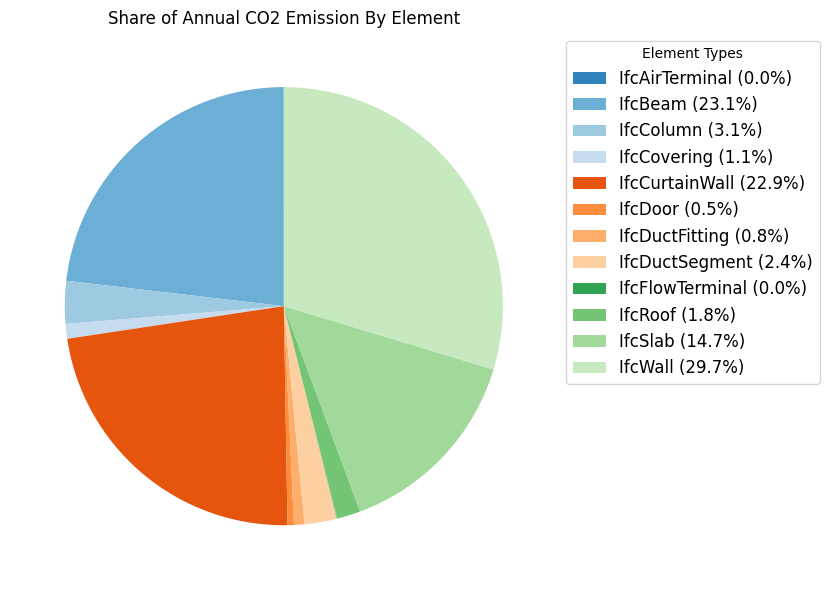

In [576]:
plt.figure(figsize=(8, 6))
colors = cm.tab20c(range(len(total_element_co2))) 

total = total_element_co2['Annual_Co2'].sum()
percentages = (total_element_co2['Annual_Co2'] / total) * 100
legend_labels = [
    f"{name} ({value:.1f}%)"
    for name, value in zip(total_element_co2['ElementName'], percentages)
]

wedges, texts = plt.pie(
    total_element_co2['Annual_Co2'], 
    labels=None, 
    colors=colors, 
    startangle=90
)

plt.legend(
    wedges, 
    legend_labels, 
    title="Element Types", 
    loc="best", 
    bbox_to_anchor=(1, 1), 
    fontsize='large'
)

plt.title('Share of Annual CO2 Emission By Element')
plt.tight_layout()
plt.show()


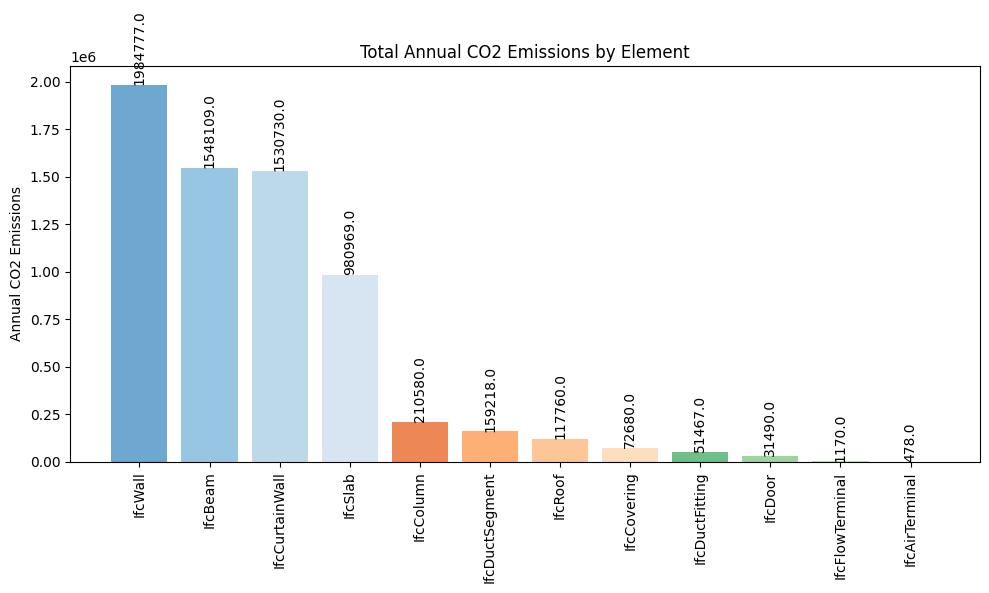

In [577]:
sorted_data = total_element_co2.sort_values(by='Annual_Co2', ascending=False)
colors = cm.tab20c(range(len(total_element_co2)))
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_data['ElementName'], 
               sorted_data['Annual_Co2'], 
               color=colors, 
               alpha=0.7)

for bar in bars:
    height = np.round(bar.get_height())
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, 
             ha='center', va='bottom', rotation=90, fontsize=10)

plt.xticks(sorted_data['ElementName'], rotation=90)
plt.ylabel('Annual CO2 Emissions')

plt.title('Total Annual CO2 Emissions by Element')
plt.tight_layout()
plt.show()